In [2]:
import numpy as np
import pandas as pd
import math
from numpy.linalg import *
import time

In [78]:

#input term
trfname='veh.dat'
tstfname='vehtest.dat'
form=','
header=None


cl=19
col = int(cl)-1

train = np.genfromtxt(trfname, delimiter=',')
test = np.genfromtxt(tstfname, delimiter=',')

#calculate term
X = np.delete(train, col, 1) # input variable
Y = train[:,col] # target variable

n = len(train) # number of obs
p = X.shape[1] # number of variables

testX = np.delete(test, col, 1) # input variable
testY = test[:,col] # target variable

g = np.array(list(set(Y))) # unique value of target variable
k = len(g) # number of unique values

#calculate mean of each variables by y values
tmp=[]
for i in g:
    tmp.append(X[np.where(train[:,col]==i)])
xby = np.array(tmp)
xbar = np.array(list(map(lambda x : np.mean(x,axis=0),xby)))

#prior probability
pw=[]
for i in range(k):
    pw.append(xby[i].shape[0]/n)
pw = np.array(pw)

#np.cov(xby[0].transpose())
S0 = np.array(list(map(lambda x : np.cov(x.transpose()) , xby)))


sigma =np.zeros((p,p))
for i in range(k):
    sigma = sigma + (xby[i].shape[0]-1)*S0[i]
Sp=sigma*(1/(n-k))

def dk(vec, S = S0):
    out=[]
    for i in range(k):
        out.append(-0.5*(math.log(det(S[i])))-0.5*((vec-xbar[i]).dot(inv(S[i])).dot((vec-xbar[i]).transpose())) +math.log(pw[i]))
    return(out)
def pred(vec):
    out=pd.DataFrame(g).loc[pd.DataFrame([g,vec]).iloc[1]==max(pd.DataFrame([g,vec]).iloc[1])].iloc[0][0]
    return(out)

tp = np.array(list(map(dk,X)))
yhat = np.argmax(tp,axis =1)
cont = pd.crosstab(Y,yhat)
acc = sum(np.diag(cont))/n
s2=np.diag(Sp).mean()
def getacc(Sk ,a,r):
    Sar = a*Sk + (1 - a)*(r*Sp + (1 - r)*s2*np.identity(p))
    tp2 = np.array(list(map(lambda x : dk(x,Sar),X)))
    yhatg = np.argmax(tp2,axis =1)
    contg = pd.crosstab(Y,yhatg)
    acc2 = sum(np.diag(contg))/n
    return(acc2)
#ready for grid search
df = pd.DataFrame()
for i in range(21):
    df=df.append(pd.DataFrame(np.zeros(21)).transpose())
alpha = gamma = list(map(lambda x : x/20 , list(range(21))))
df.columns=alpha
df.index=gamma
for a ,i in zip(alpha , range(21)):
    if i%2 == 0:
        print("%d percent completed" %(i*5))
    for r, j in zip(gamma, range(21)) :
        df.iloc[i,j]= getacc(S0,a,r)
#get the optimized value of alpha & gamma (alpha = 0.53, beta = 1)
argm=df.stack().index[np.argmax(df.values)]
a = argm[0]
r = argm[1]
Snew = a*S0 + (1 - a)*(r*Sp + (1 - r)*s2*np.identity(p))

#resub output
tp = np.array(list(map(lambda x : dk(x,Snew),X)))
yhat = np.argmax(tp,axis =1)
cont = pd.crosstab(Y,yhat)
acc = sum(np.diag(cont))/n

#test output
ttp = np.array(list(map(lambda x : dk(x,Snew),testX)))
tyhat = np.argmax(ttp,axis =1)
tcont = pd.crosstab(testY,tyhat)
tacc = sum(np.diag(tcont))/len(test)
#print(tp)
print(yhat)
print(cont)
print(acc)

#print(ttp)
print(tyhat)
print(tcont)
print(tacc)

0 percent completed
10 percent completed
20 percent completed
30 percent completed
40 percent completed
50 percent completed
60 percent completed
70 percent completed
80 percent completed
90 percent completed
100 percent completed
[0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0
 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 0 3 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 

In [13]:
def getacc(Sk ,a,r):
    Sar = a*Sk + (1 - a)*(r*Sp + (1 - r)*s2*np.identity(p))
    tp2 = np.array(list(map(lambda x : dk(x,Sar),testX)))
    yhatg = np.argmax(tp2,axis =1)
    contg = pd.crosstab(testY,yhatg)
    acc2 = sum(np.diag(contg))/len(test)
    return(acc2)

In [14]:
getacc(S0,0.95,1)

0.8333333333333334

In [35]:
Sp

array([[ 9.68584070e+00,  5.05606099e+00,  1.30717091e+01,
         2.58041945e+01,  1.72521164e+00,  9.16322689e-01,
         2.94440731e+01, -6.60903354e+00,  2.30231394e+00,
         1.20322957e+01,  2.64033869e+01,  1.59488090e+02,
         2.25723134e+01, -1.43808709e+00,  1.61541201e+00,
         8.63856410e-01,  2.40850384e+00,  2.97285109e+00],
       [ 5.05606099e+00,  5.66203429e+00,  1.03844424e+01,
         1.60634061e+01,  1.03238544e+00,  1.13753566e+00,
         2.36535903e+01, -5.15814326e+00,  1.86592072e+00,
         1.33686680e+01,  2.05358107e+01,  1.25570231e+02,
         2.79617210e+01,  7.33488462e-01,  9.46120864e-01,
        -5.69239891e-01, -7.70142235e-01,  1.03052090e-01],
       [ 1.30717091e+01,  1.03844424e+01,  2.94360596e+01,
         4.78013470e+01,  4.05516835e+00,  2.76652571e+00,
         5.68198494e+01, -1.31792223e+01,  4.39942940e+00,
         2.50560075e+01,  5.16105315e+01,  2.99467280e+02,
         4.84208594e+01, -1.64289514e+00,  1.26749438e

In [31]:
(S0+Sp)[:,0,0]

array([77.79976011, 93.16282151, 81.9947648 , 25.65301241])

In [113]:
np.arange(0., 1.001, 0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [1]:


train = np.genfromtxt(trfname, delimiter=form, skip_header=0)
test = np.genfromtxt(tstfname, delimiter=form, skip_header=0)

#calculate term
X = np.delete(train, col, 1) # input variable
Y = train[:,col] # target variable

n = len(train) # number of obs
p = X.shape[1] # number of variables

testX = np.delete(test, col, 1) # input variable
testY = test[:,col] # target variable

g = np.array(list(set(Y))) # unique value of target variable
k = len(g) # number of unique values

#calculate mean of each variables by y values
tmp=[]
for i in g:
    tmp.append(X[np.where(train[:,col]==i)])
xby = np.array(tmp)
xbar = np.array(list(map(lambda x : np.mean(x,axis=0),xby)))

#prior probability
pw=[]
for i in range(k):
    pw.append(xby[i].shape[0]/n)
pw = np.array(pw)

#np.cov(xby[0].transpose())
S0 = np.array(list(map(lambda x : np.cov(x.transpose()) , xby)))

# ready for calculate covariance matrix
sigma =np.zeros((p,p))
for i in range(k):
    sigma = sigma + (X[i].shape[0]-1)*S0[i]
Sp=sigma*(1/(n-k))

def dk(vec, S = S0):
    out=[]
    for i in range(k):
        out.append(-0.5*(math.log(det(S[i])))-0.5*((vec-xbar[i]).dot(inv(S[i])).dot((vec-xbar[i]).transpose())) +math.log(pw[i]))
    return(out)
def pred(vec):
    out=pd.DataFrame(g).loc[pd.DataFrame([g,vec]).iloc[1]==max(pd.DataFrame([g,vec]).iloc[1])].iloc[0][0]
    return(out)

tp = np.array(list(map(dk,X)))
yhat = np.argmax(tp,axis =1)
cont = pd.crosstab(Y,yhat)
acc = sum(np.diag(cont))/n

#ready for grid search
s2=np.diag(Sp).mean()

def getacc(Sk ,a,r):
    Sar = a*Sk + (1 - a)*(r*Sp + (1 - r)*s2*np.identity(p))
    tp2 = np.array(list(map(lambda x : dk(x,Sar),testX)))
    yhatg = np.argmax(tp2,axis =1)
    contg = pd.crosstab(testY,yhatg)
    acc2 = sum(np.diag(contg))/n
    return(acc2)

df = pd.DataFrame()
gridseed=21
for i in range(gridseed):
    df=df.append(pd.DataFrame(np.zeros(gridseed)).transpose())
alpha = gamma = list(map(lambda x : x/(gridseed-1) , list(range(gridseed))))
df.columns=alpha
df.index=gamma
for a ,i in zip(alpha , range(gridseed)):
    if i%2 == 0:
        print("%d percent completed" %(i*5))
    for r, j in zip(gamma, range(gridseed)) :
        df.iloc[i,j]= getacc(S0,a,r)
#get the optimized value of alpha & gamma (alpha = 0.53, beta = 1)
argm=df.stack().index[np.argmax(df.values)]
a = 0.95#argm[0]
r = argm[1]
Snew = a*S0 + (1 - a)*(r*Sp + (1 - r)*s2*np.identity(p))

#resub output
tp = np.array(list(map(lambda x : dk(x,Snew),X)))
yhat = np.argmax(tp,axis =1)
cont = pd.crosstab(Y,yhat)
acc = sum(np.diag(cont))/n

#test output
ttp = np.array(list(map(lambda x : dk(x,Snew),testX)))
tyhat = np.argmax(ttp,axis =1)
tcont = pd.crosstab(testY,tyhat)
tacc = sum(np.diag(tcont))/len(test)


predy = pd.DataFrame([range(1,(len(train)+1)),Y,yhat]).transpose()
predy.columns=['ID','Actual class','Resub pred']

tpredy = pd.DataFrame([range(1,(len(test)+1)),testY,tyhat]).transpose()
tpredy.columns=['ID','Actual class','Test pred']

cont.columns = g
cont.index = g
cont.columns.name = 'Resub Class'
cont.index.name = 'Actual Class'

tcont.columns = g
tcont.index = g
tcont.columns.name = 'Prediction Class'
tcont.index.name = 'Actual Class'
fname = input('Write your output file name : ')
#console output
print(predy.to_string(index=False))
print(cont)
print("Overall accuracy = %0.3f" %(acc))

print(tpredy.to_string(index=False))
print(tcont)
print("Overall accuracy = %0.3f" %(tacc))



NameError: name 'np' is not defined

In [116]:
argm

(0.65, 1.0)

In [119]:
Snew.shape

(4, 18, 18)

In [120]:
S0.shape

(4, 18, 18)

In [121]:
Snew

array([[[ 65.19251548,  44.99693309,  95.91474846, ...,  -8.44590974,
          17.55631805,  22.92906838],
        [ 44.99693309,  51.92464933,  87.8627615 , ..., -15.9074684 ,
           0.86999564,   7.21497403],
        [ 95.91474846,  87.8627615 , 212.24357038, ...,   3.74667104,
          17.83684506,  31.69259624],
        ...,
        [ -8.44590974, -15.9074684 ,   3.74667104, ..., 102.04377416,
           2.12213835,  12.17378118],
        [ 17.55631805,   0.86999564,  17.83684506, ...,   2.12213835,
          30.55486922,  29.45360552],
        [ 22.92906838,   7.21497403,  31.69259624, ...,  12.17378118,
          29.45360552,  32.41383208]],

       [[ 79.78742381,  46.9124611 , 115.31105835, ...,  12.07998598,
           7.27244354,  25.83358417],
        [ 46.9124611 ,  41.63654625,  82.93453488, ...,  -1.22313255,
          -1.81125941,  11.14732942],
        [115.31105835,  82.93453488, 234.06539764, ...,  38.27263942,
           5.83465242,  40.638645  ],
        ...,


In [122]:
S0

array([[[ 68.11391941,  47.09908425, 100.27490842, ...,  -8.93589744,
          18.35357143,  23.9793956 ],
        [ 47.09908425,  54.35952381,  91.94056777, ..., -16.71474359,
           0.95631868,   7.58928571],
        [100.27490842,  91.94056777, 221.86501832, ...,   3.77564103,
          18.68159341,  33.13873626],
        ...,
        [ -8.93589744, -16.71474359,   3.77564103, ..., 106.80128205,
           2.22115385,  12.75      ],
        [ 18.35357143,   0.95631868,  18.68159341, ...,   2.22115385,
          31.82362637,  30.65659341],
        [ 23.9793956 ,   7.58928571,  33.13873626, ...,  12.75      ,
          30.65659341,  33.70604396]],

       [[ 83.47698082,  49.11542952, 120.69207673, ...,  12.67030859,
           7.52844037,  27.03678065],
        [ 49.11542952,  43.52994162,  86.7529608 , ...,  -1.25754796,
          -1.86605505,  11.72860717],
        [120.69207673,  86.7529608 , 244.8353628 , ...,  40.11876564,
           6.04770642,  42.55562969],
        ...,


In [32]:
Sp[0,0]

9.685840695680742

In [10]:
sigma =np.zeros((p,p))
for i in range(k):
    sigma = sigma + (xby[i].shape[0]-1)*S0[i]
Sp=sigma*(1/(n-k))


In [6]:
sigma = pd.DataFrame(np.zeros((p,p)))
for i in range(k):
    sigma = sigma + (X[i].shape[0]-1)*S0[i]
Sp=sigma*(1/(n-k))

In [11]:
Sp

array([[ 6.09151099e+01,  3.17530452e+01,  8.21434993e+01,
         1.62409663e+02,  1.08031558e+01,  5.67306711e+00,
         1.85645377e+02, -4.15811801e+01,  1.45214286e+01,
         7.53308562e+01,  1.66589645e+02,  1.00663420e+03,
         1.42185624e+02, -8.84507820e+00,  1.01532102e+01,
         5.63454617e+00,  1.50293858e+01,  1.85939168e+01],
       [ 3.17530452e+01,  3.52565440e+01,  6.47344525e+01,
         1.00205499e+02,  6.25725144e+00,  6.97271267e+00,
         1.47970511e+02, -3.21361800e+01,  1.16824160e+01,
         8.30954372e+01,  1.28564134e+02,  7.86959705e+02,
         1.74271128e+02,  4.65145202e+00,  5.97703016e+00,
        -3.39838192e+00, -4.81240584e+00,  5.32088719e-01],
       [ 8.21434993e+01,  6.47344525e+01,  1.83258063e+02,
         2.98138357e+02,  2.47721652e+01,  1.68575826e+01,
         3.55879562e+02, -8.21556664e+01,  2.75869257e+01,
         1.55658372e+02,  3.23346791e+02,  1.87951087e+03,
         3.02615559e+02, -9.76644106e+00,  8.03769308e

In [9]:
X.shape

(425, 18)

In [15]:
df.loc

,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
0.00,0.385882,0.383529,0.385882,0.392941,0.397647,0.404706,0.404706,0.409412,0.414118,0.423529,...,0.449412,0.470588,0.487059,0.510588,0.543529,0.574118,0.602353,0.628235,0.687059,0.840000
0.05,0.397647,0.378824,0.390588,0.400000,0.409412,0.416471,0.421176,0.423529,0.425882,0.432941,...,0.458824,0.470588,0.484706,0.517647,0.548235,0.597647,0.630588,0.661176,0.703529,0.847059
0.10,0.414118,0.411765,0.421176,0.423529,0.425882,0.430588,0.432941,0.432941,0.442353,0.451765,...,0.472941,0.484706,0.494118,0.524706,0.569412,0.607059,0.651765,0.675294,0.720000,0.863529
0.15,0.423529,0.432941,0.435294,0.435294,0.437647,0.447059,0.451765,0.458824,0.468235,0.470588,...,0.482353,0.494118,0.517647,0.534118,0.581176,0.611765,0.658824,0.682353,0.729412,0.877647
0.20,0.437647,0.451765,0.447059,0.454118,0.454118,0.454118,0.465882,0.475294,0.475294,0.477647,...,0.494118,0.501176,0.522353,0.543529,0.585882,0.616471,0.663529,0.684706,0.741176,0.877647
0.25,0.437647,0.440000,0.449412,0.449412,0.451765,0.463529,0.470588,0.472941,0.482353,0.489412,...,0.505882,0.510588,0.520000,0.543529,0.583529,0.621176,0.663529,0.694118,0.748235,0.877647
0.30,0.444706,0.442353,0.451765,0.463529,0.465882,0.477647,0.477647,0.489412,0.491765,0.496471,...,0.498824,0.508235,0.522353,0.550588,0.583529,0.628235,0.677647,0.710588,0.757647,0.894118
0.35,0.463529,0.465882,0.475294,0.477647,0.487059,0.484706,0.482353,0.487059,0.487059,0.494118,...,0.496471,0.510588,0.524706,0.548235,0.592941,0.644706,0.684706,0.720000,0.767059,0.903529
0.40,0.463529,0.477647,0.482353,0.482353,0.482353,0.487059,0.484706,0.489412,0.489412,0.487059,...,0.503529,0.512941,0.524706,0.550588,0.597647,0.656471,0.691765,0.729412,0.774118,0.910588
0.45,0.477647,0.482353,0.484706,0.484706,0.484706,0.484706,0.489412,0.489412,0.487059,0.489412,...,0.501176,0.508235,0.531765,0.560000,0.625882,0.665882,0.701176,0.734118,0.776471,0.917647


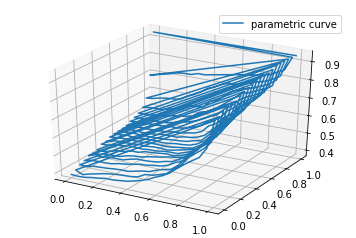

In [81]:
#import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np                #  뭔가 많이 import 시켰다. 그냥 그른가부다 하고 넘어가자.
import matplotlib.pyplot as plt   #  여러분이 코딩을 할땐 그냥 복붙하여 사용하면 된다.
# import 어쩌고 as 저쩌고 라는 코드는 from 어쩌고 import 와 비슷하다. 다만 코드를 칠때마다 "저쩌고.어쩌고 안의 기능"이라고 해야 코드가 작동한다.
# 바로 아래코드도 보면 mpl.rcParams[~~~] 이라고 써있다. rcParams 를 바로 쓰지 않는다.
%matplotlib inline  

#mpl.rcParams['legend.fontsize'] = 10			# 그냥 오른쪽 위에 뜨는 글자크기 설정이다.

fig = plt.figure()								# 이건 꼭 입력해야한다.
ax = fig.gca(projection='3d')
#theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)	# 각도의 범위는 -4파이 에서 +4파이
#z = df.loc[x,y]						# z는 -2부터 2까지 올라간다.
#r = z**2 + 1									# z값이 변함에 따라 반지름이 바뀔 것이다. 
x = np.array(alpha*21)							# 나선구조를 만들기 위해 x는 sin함수
y = np.repeat(alpha,21)							# 나선구조를 만들기 위해 y는 cos함수
z = df.values.reshape((21*21,1))[:,0]
ax.plot(x, y, z, label='parametric curve')		# 위에서 정의한 x,y,z 가지고 그래프그린거다.
ax.legend()										# 오른쪽 위에 나오는 글자 코드다. 이거 없애면 글자 사라진다. 없애도 좋다.

plt.show()

In [44]:
list(alpha)

[0.0,
 0.05,
 0.1,
 0.15,
 0.2,
 0.25,
 0.3,
 0.35,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6,
 0.65,
 0.7,
 0.75,
 0.8,
 0.85,
 0.9,
 0.95,
 1.0]

In [18]:
df.iloc[0,0]

0.38588235294117645

In [29]:
df.loc[0.05,0.05]

0.3788235294117647

In [42]:
pd.DataFrame(df.stack()).index

MultiIndex(levels=[[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 

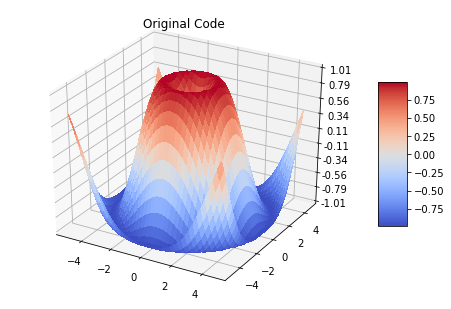

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

## Matplotlib Sample Code using 2D arrays via meshgrid
X = alpha
Y = beta
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X ** 2 + Y ** 2)
Z = np.sin(R)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(-1.01, 1.01)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Original Code')
plt.show()

In [47]:
df

,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0
0.00,0.385882,0.383529,0.385882,0.392941,0.397647,0.404706,0.404706,0.409412,0.414118,0.423529,...,0.449412,0.470588,0.487059,0.510588,0.543529,0.574118,0.602353,0.628235,0.687059,0.840000
0.05,0.397647,0.378824,0.390588,0.400000,0.409412,0.416471,0.421176,0.423529,0.425882,0.432941,...,0.458824,0.470588,0.484706,0.517647,0.548235,0.597647,0.630588,0.661176,0.703529,0.847059
0.10,0.414118,0.411765,0.421176,0.423529,0.425882,0.430588,0.432941,0.432941,0.442353,0.451765,...,0.472941,0.484706,0.494118,0.524706,0.569412,0.607059,0.651765,0.675294,0.720000,0.863529
0.15,0.423529,0.432941,0.435294,0.435294,0.437647,0.447059,0.451765,0.458824,0.468235,0.470588,...,0.482353,0.494118,0.517647,0.534118,0.581176,0.611765,0.658824,0.682353,0.729412,0.877647
0.20,0.437647,0.451765,0.447059,0.454118,0.454118,0.454118,0.465882,0.475294,0.475294,0.477647,...,0.494118,0.501176,0.522353,0.543529,0.585882,0.616471,0.663529,0.684706,0.741176,0.877647
0.25,0.437647,0.440000,0.449412,0.449412,0.451765,0.463529,0.470588,0.472941,0.482353,0.489412,...,0.505882,0.510588,0.520000,0.543529,0.583529,0.621176,0.663529,0.694118,0.748235,0.877647
0.30,0.444706,0.442353,0.451765,0.463529,0.465882,0.477647,0.477647,0.489412,0.491765,0.496471,...,0.498824,0.508235,0.522353,0.550588,0.583529,0.628235,0.677647,0.710588,0.757647,0.894118
0.35,0.463529,0.465882,0.475294,0.477647,0.487059,0.484706,0.482353,0.487059,0.487059,0.494118,...,0.496471,0.510588,0.524706,0.548235,0.592941,0.644706,0.684706,0.720000,0.767059,0.903529
0.40,0.463529,0.477647,0.482353,0.482353,0.482353,0.487059,0.484706,0.489412,0.489412,0.487059,...,0.503529,0.512941,0.524706,0.550588,0.597647,0.656471,0.691765,0.729412,0.774118,0.910588
0.45,0.477647,0.482353,0.484706,0.484706,0.484706,0.484706,0.489412,0.489412,0.487059,0.489412,...,0.501176,0.508235,0.531765,0.560000,0.625882,0.665882,0.701176,0.734118,0.776471,0.917647


In [72]:
df.values.reshape((21*21,1))[:,0]

array([0.38588235, 0.38352941, 0.38588235, 0.39294118, 0.39764706,
       0.40470588, 0.40470588, 0.40941176, 0.41411765, 0.42352941,
       0.43529412, 0.44941176, 0.47058824, 0.48705882, 0.51058824,
       0.54352941, 0.57411765, 0.60235294, 0.62823529, 0.68705882,
       0.84      , 0.39764706, 0.37882353, 0.39058824, 0.4       ,
       0.40941176, 0.41647059, 0.42117647, 0.42352941, 0.42588235,
       0.43294118, 0.45411765, 0.45882353, 0.47058824, 0.48470588,
       0.51764706, 0.54823529, 0.59764706, 0.63058824, 0.66117647,
       0.70352941, 0.84705882, 0.41411765, 0.41176471, 0.42117647,
       0.42352941, 0.42588235, 0.43058824, 0.43294118, 0.43294118,
       0.44235294, 0.45176471, 0.45647059, 0.47294118, 0.48470588,
       0.49411765, 0.52470588, 0.56941176, 0.60705882, 0.65176471,
       0.67529412, 0.72      , 0.86352941, 0.42352941, 0.43294118,
       0.43529412, 0.43529412, 0.43764706, 0.44705882, 0.45176471,
       0.45882353, 0.46823529, 0.47058824, 0.47764706, 0.48235

In [65]:
np.array(alpha*21)

(441,)

In [67]:
np.repeat(alpha,21)

(441,)

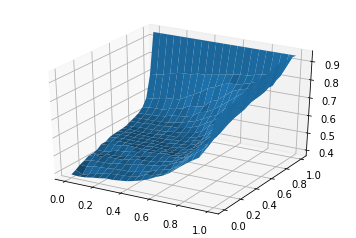

In [82]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

x = df.columns
y = df.index
X,Y = np.meshgrid(x,y)
Z = df
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()

In [76]:
df

,0,1,2,3
0,-0.913970,2.054881,0.191920,2.482016
1,0.757890,-0.053197,-1.423535,-0.866245
2,-0.552961,0.512036,-0.110885,-0.438867
3,-0.256275,-0.313340,1.534020,-1.500709
4,1.306154,0.686018,-0.524541,-0.415671


In [77]:
?np.meshgrid